# DQN для Pong (полносвязная сеть, 1 канал)

**Задание:** решить задачу `Pong` с помощью DQN, используя **только полносвязанные слои** и **один канал** (grayscale).

Ограничения и подсказки основаны на текущих ноутбуках в папке `PONG`:
- среда `PongDeterministic-v4` (Gymnasium + ALE),
- используем подмножество действий `NOOP`, `UP`, `DOWN`,
- уменьшаем размер изображения до `84×84`.

Параметры обучения (число эпизодов, размер буфера, ε и т.д.) подберите под доступные ресурсы.

## 1. Установка зависимостей

In [1]:
!pip -q install "gymnasium[atari]" autorom[accept-rom-license]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 14.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


## 2. Импорт библиотек и создание среды

In [4]:
import gymnasium as gym
import ale_py
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
from PIL import Image

# Регистрация Atari окружений
gym.register_envs(ale_py)

# Устройство
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Среда Pong (актуальный ID в Gymnasium)
env = gym.make("ALE/Pong-v5", frameskip=4, repeat_action_probability=0.0)

# Доступные действия
print("Actions:", env.unwrapped.get_action_meanings())


Device: cuda
Actions: ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']


## 3. Подмножество действий
Из исходного ноутбука оставим 3 действия: `NOOP`, `UP`, `DOWN`.

In [5]:
ACTIONS = [0, 2, 3]  # NOOP, UP, DOWN
n_action = len(ACTIONS)

## 4. Предобработка: один канал (grayscale) + 84×84

In [6]:
IMAGE_SIZE = 64
CROP_TOP = 34
CROP_BOTTOM = 194


def preprocess_frame(obs):
    # Crop static scoreboard/background area, keep playing field only.
    img = Image.fromarray(obs).convert("L")
    arr = np.array(img, dtype=np.uint8)
    arr = arr[CROP_TOP:CROP_BOTTOM, :]
    img = Image.fromarray(arr)
    img = img.resize((IMAGE_SIZE, IMAGE_SIZE), Image.BILINEAR)
    frame = np.array(img, dtype=np.float32) / 255.0
    return frame


def get_state(obs, prev_frame=None):
    # 1-channel temporal input: current frame minus previous frame.
    frame = preprocess_frame(obs)
    if prev_frame is None:
        diff = np.zeros_like(frame, dtype=np.float32)
    else:
        diff = frame - prev_frame
    return diff.reshape(1, -1), frame


# Sanity check
obs, _ = env.reset()
state, frame = get_state(obs, None)
print("State shape:", state.shape)

State shape: (1, 4096)


## 5. DQN с **полносвязными слоями**

In [7]:
class MLP(nn.Module):
    def __init__(self, input_dim, n_action):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, n_action)
        )

    def forward(self, x):
        return self.net(x)


class DQN:
    def __init__(self, input_dim, n_action, lr=2e-4):
        self.criterion = nn.SmoothL1Loss()
        self.model = MLP(input_dim, n_action).to(device)
        self.model_target = MLP(input_dim, n_action).to(device)
        self.model_target.load_state_dict(self.model.state_dict())
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)

    def copy_target(self):
        self.model_target.load_state_dict(self.model.state_dict())

    def predict(self, s):
        with torch.no_grad():
            s_t = torch.tensor(s, dtype=torch.float32, device=device)
            return self.model(s_t)

    def target_predict(self, s):
        with torch.no_grad():
            s_t = torch.tensor(s, dtype=torch.float32, device=device)
            return self.model_target(s_t)

    def update(self, s, y):
        s_t = torch.tensor(s, dtype=torch.float32, device=device)
        y_t = torch.tensor(y, dtype=torch.float32, device=device)
        y_pred = self.model(s_t)
        loss = self.criterion(y_pred, y_t)
        self.optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(self.model.parameters(), 10.0)
        self.optimizer.step()

    def replay(self, memory, replay_size, gamma):
        if len(memory) < replay_size:
            return

        batch = random.sample(memory, replay_size)
        states = []
        td_targets = []

        for state, action, next_state, reward, done in batch:
            q_values = self.predict(state).cpu().numpy()[0]
            if done:
                q_values[action] = reward
            else:
                # Double DQN target:
                # online net chooses action, target net evaluates it.
                next_q_online = self.predict(next_state).cpu().numpy()[0]
                best_next_action = int(np.argmax(next_q_online))
                next_q_target = self.target_predict(next_state).cpu().numpy()[0]
                q_values[action] = reward + gamma * next_q_target[best_next_action]

            states.append(state[0])
            td_targets.append(q_values)

        self.update(states, td_targets)

## 6. ε-жадная стратегия

In [8]:
def gen_epsilon_greedy_policy(estimator, epsilon, n_action):
    def policy_function(state):
        if random.random() < epsilon:
            return random.randint(0, n_action - 1)
        else:
            q_values = estimator.predict(state)
            return torch.argmax(q_values).item()
    return policy_function

## 7. Гиперпараметры
Подберите значения под доступные ресурсы. Ниже — стартовые, как в исходном ноутбуке (уменьшены для скорости).

In [9]:
input_dim = IMAGE_SIZE * IMAGE_SIZE
n_episode = 80
replay_size = 32
memory_size = 10000
lr = 2e-4
gamma = 0.99

target_update = 20
train_every = 2
learning_starts = 2000

epsilon = 1.0
epsilon_decay = 0.99
epsilon_min = 0.05

max_steps_per_episode = 3000

memory = deque(maxlen=memory_size)

total_reward_episode = [0] * n_episode

dqn = DQN(input_dim, n_action, lr)

## 8. Обучение DQN

Episode: 79 | Reward: -21.0 | Avg20: -21.00 | epsilon: 0.452 | memory: 10000


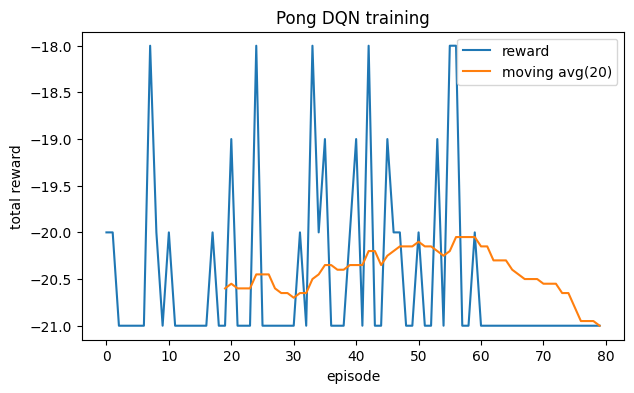

In [10]:
from IPython.display import clear_output
import matplotlib.pyplot as plt

# interactive chart refresh period (episodes)
display_every = 5


def q_learning(env, estimator, n_episode, replay_size, target_update=20, gamma=0.99,
               epsilon=1.0, epsilon_decay=0.99, epsilon_min=0.05,
               train_every=2, learning_starts=2000):
    global_step = 0

    for episode in range(n_episode):
        if episode % target_update == 0:
            estimator.copy_target()

        policy = gen_epsilon_greedy_policy(estimator, epsilon, n_action)
        obs, _ = env.reset()
        state, prev_frame = get_state(obs, None)

        for step in range(max_steps_per_episode):
            action_idx = policy(state)
            next_obs, reward, done, truncated, _ = env.step(ACTIONS[action_idx])
            total_reward_episode[episode] += reward

            next_state, next_frame = get_state(next_obs, prev_frame)
            memory.append((state, action_idx, next_state, reward, done or truncated))

            if global_step >= learning_starts and global_step % train_every == 0:
                estimator.replay(memory, replay_size, gamma)

            state = next_state
            prev_frame = next_frame
            global_step += 1

            if done or truncated:
                break

        if (episode == 0) or ((episode + 1) % display_every == 0) or (episode == n_episode - 1):
            clear_output(wait=True)
            window = total_reward_episode[max(0, episode - 19):episode + 1]
            avg_20 = float(np.mean(window))
            print(
                f"Episode: {episode} | Reward: {total_reward_episode[episode]:.1f} | "
                f"Avg20: {avg_20:.2f} | epsilon: {epsilon:.3f} | memory: {len(memory)}"
            )

            plt.figure(figsize=(7, 4))
            rewards = np.array(total_reward_episode[:episode + 1], dtype=np.float32)
            plt.plot(rewards, label="reward")
            if len(rewards) >= 20:
                ma = np.convolve(rewards, np.ones(20) / 20, mode="valid")
                x = np.arange(19, len(rewards))
                plt.plot(x, ma, label="moving avg(20)")
            plt.title("Pong DQN training")
            plt.xlabel("episode")
            plt.ylabel("total reward")
            plt.legend()
            plt.show()

        epsilon = max(epsilon * epsilon_decay, epsilon_min)


q_learning(
    env,
    dqn,
    n_episode,
    replay_size,
    target_update=target_update,
    gamma=gamma,
    epsilon=epsilon,
    epsilon_decay=epsilon_decay,
    epsilon_min=epsilon_min,
    train_every=train_every,
    learning_starts=learning_starts,
)

## Тест обученной стратегии

In [12]:
obs, _ = env.reset()
state, prev_frame = get_state(obs, None)
policy = gen_epsilon_greedy_policy(dqn, epsilon=0.0, n_action=n_action)

total_reward = 0
for step in range(3000):
    action_idx = policy(state)
    next_obs, reward, done, truncated, _ = env.step(ACTIONS[action_idx])
    total_reward += reward
    state, prev_frame = get_state(next_obs, prev_frame)
    if done or truncated:
        break

print("Total reward (test):", total_reward)

Total reward (test): -21.0


## Вывод по результатам обучения

В рамках задания реализован DQN для Pong с ограничениями: только полносвязная сеть и один канал входа (grayscale). Обучение проведено на 80 эпизодах с ограниченным вычислительным бюджетом.

Полученные результаты:

Эпизодические награды в основном находятся в диапазоне -21 ... -20.
Редко наблюдаются улучшения до -19 и -18, но они не закрепляются.
На финале: Episode 79, Reward = -21.0, Avg20 = -21.00, epsilon = 0.452, что указывает на отсутствие устойчивого прогресса.
Итог:

Пайплайн обучения работает корректно (агент иногда демонстрирует поведение лучше базового), но стабильной обученной стратегии за доступное время получить не удалось.
При текущих ограничениях (FC + 1 канал) и выбранном числе эпизодов качество закономерно остается низким; для заметного улучшения нужен существенно больший бюджет обучения.